## Data Preparation & Exploratory Data Analysis (EDA)

### 1) Import necessary libraries, data

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_curve, make_scorer 

import torch
import torch.nn as nn
import random

from custom_functions.custom_cv_functions import GridSearchCV_fun, get_scores
from custom_functions.custom_data_imputing import IterativeKNNImputer
from custom_functions.custom_neural_network import stratified_cross_validate_nn_with_optimal_threshold, nn_predictions

import warnings
warnings.filterwarnings('ignore')  # early-stop warnings etc

Using device: cuda


In [45]:
# Set the random seed for reproducibility
random_state = 42
torch.manual_seed(random_state)  # PyTorch CPU random seed
torch.cuda.manual_seed_all(random_state)  # PyTorch GPU random seed
np.random.seed(random_state)  # NumPy random seed
random.seed(random_state)  # Python's random seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Basic Data Overview
data = pd.read_csv('data/train_dataset.csv', index_col=0)
data_test = pd.read_csv('data/test_dataset.csv', index_col=0)

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         5530 non-null   float64
 1   Gender                      6359 non-null   float64
 2   Reviews_Read                6373 non-null   float64
 3   Price                       6355 non-null   float64
 4   Discount                    6376 non-null   float64
 5   Category                    6366 non-null   float64
 6   Items_In_Cart               6359 non-null   float64
 7   Time_of_Day                 6371 non-null   object 
 8   Email_Interaction           6373 non-null   float64
 9   Device_Type                 6376 non-null   object 
 10  Payment_Method              5491 non-null   object 
 11  Referral_Source             5503 non-null   object 
 12  Socioeconomic_Status_Score  6380 non-null   float64
 13  Engagement_Score            6365 non-n

Age  Gender  Reviews_Read    Price  Discount  Category  Items_In_Cart  \
Id                                                                           
0   20.0     1.0           1.0  623.797      25.0       4.0            4.0   
1   22.0     0.0           5.0  549.324      50.0       4.0            8.0   
2   18.0     0.0           2.0  489.191      19.0       0.0            5.0   
3   25.0     0.0           3.0  769.450      16.0       4.0            5.0   
4   22.0     1.0           2.0   39.308      35.0       0.0            3.0   

   Time_of_Day  Email_Interaction Device_Type Payment_Method Referral_Source  \
Id                                                                             
0    afternoon                0.0     Desktop         PayPal          Direct   
1      evening                0.0     Desktop           Bank   Search_engine   
2    afternoon                0.0      Mobile           Bank           Email   
3      evening                0.0      Mobile         Credit    Social_media   
4      evening                0.0      Mobile            NaN           Email   

    Socioeconomic_Status_Score  Engagement_Score  Purchase  
Id                                                          
0                         9.13          2.167873         0  
1                         9.53          3.494243         0  
2                         0.70          2.093568         0  
3                         6.83          3.644859         0  
4                         1.86          4.171256         1

### 2) Do categorical features initial encoding

In [3]:
# cols
numerical_cols = ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Engagement_Score']
categorical_cols = ['Gender', 'Category', 'Time_of_Day', 'Email_Interaction', 'Device_Type', 'Payment_Method', 'Referral_Source']

In [4]:
# Check categorical features
print(data['Time_of_Day'].unique(), 
      data['Device_Type'].unique(), 
      data['Payment_Method'].unique(), 
      data['Referral_Source'].unique(), 
      sep='\n\n') 

['afternoon' 'evening' 'morning' 'eVening' 'afteRn00n' nan 'aftErNooN'
 'morNing' 'morninG' 'eveNing' 'evEninG' 'afteRnoon' 'aftern0on' 'morniNg'
 'Afternoon' 'Evening' 'eVEning' 'eveNiNg' 'evenIng' 'afterNoon' 'evenINg'
 'aftERnooN' 'm0RnIng' 'aFterNoon' 'afternoOn' 'afterno0n' 'eveninG'
 'afternO0n' 'afternOon' 'afternooN' 'm0rnIng' 'aFtErnO0n' 'evEniNg'
 'moRning' 'eveniNg']

['Desktop' 'Mobile' nan 'Tablet']

['PayPal' 'Bank' 'Credit' nan 'Cash' 'CreDit' 'BanK' 'BaNk' 'CaSh' 'CasH'
 'PayPaL' 'CrEdiT' 'PAyPaL' 'CAsh' 'CrEDit' 'PAyPal' 'CReDIt' 'PaYPal'
 'CrediT' 'CrEdit']

['Direct' 'Search_engine' 'Email' 'Social_media' nan 'Ads' 'SeArch_Engine'
 'SociaL_media' 'Search_eNgine' 'DiREcT' 'EMail' 'SociaL_medIa'
 'SoCial_meDia' 'EmaIl' 'SearCh_engine' 'DIrect' 'DireCt' 'AdS'
 'SeArch_engInE' 'SocIal_media' 'DirEct' 'Social_Media' 'SearCh_Engine'
 'S0cIaL_media' 'SeaRch_engine' 'SearcH_engiNe']


In [5]:
# Transform categorical columns
def categorical_transform(x):
  if not pd.isna(x):
    return str(x).lower().replace('0', 'o')

for col in categorical_cols:
  data[col] = data[col].apply(categorical_transform)
  data_test[col] = data_test[col].apply(categorical_transform)

print(data['Time_of_Day'].unique(),
      data_test['Time_of_Day'].unique(), 
      data['Device_Type'].unique(), 
      data_test['Device_Type'].unique(),
      data['Payment_Method'].unique(), 
      data_test['Payment_Method'].unique(),
      data['Referral_Source'].unique(), 
      data_test['Referral_Source'].unique(),
      sep='\n\n') 

['afternoon' 'evening' 'morning' None]

['afternoon' 'morning' 'evening' None]

['desktop' 'mobile' None 'tablet']

['mobile' 'tablet' 'desktop' None]

['paypal' 'bank' 'credit' None 'cash']

['cash' 'credit' 'paypal' 'bank' None]

['direct' 'search_engine' 'email' 'social_media' None 'ads']

['email' 'ads' 'search_engine' 'social_media' None 'direct']


In [6]:
# Custom LabelEncoder handling NaNs

le = LabelEncoder()
def label_encoder_with_nan(series):
    # Mask nan values to temporarily handle only non-nan
    non_null_values = series.dropna()
    le.fit(non_null_values)  

    return series.map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)

In [7]:
# apply data encoding

data_encoded = data.copy()
data_encoded_test = data_test.copy()
for col in categorical_cols:
    data_encoded[col] = label_encoder_with_nan(data_encoded[col])
    data_encoded_test[col] = label_encoder_with_nan(data_encoded_test[col])

# sort by num then cat features
data_encoded = data_encoded[numerical_cols+categorical_cols]
data_encoded_test = data_encoded_test[numerical_cols+categorical_cols]
data_encoded

Age  Reviews_Read    Price  Discount  Items_In_Cart  \
Id                                                           
0     20.0           1.0  623.797      25.0            4.0   
1     22.0           5.0  549.324      50.0            8.0   
2     18.0           2.0  489.191      19.0            5.0   
3     25.0           3.0  769.450      16.0            5.0   
4     22.0           2.0   39.308      35.0            3.0   
...    ...           ...      ...       ...            ...   
6495  31.0           4.0  316.049       7.0            2.0   
6496   NaN           6.0   58.784      25.0            1.0   
6497  19.0           5.0  373.853      46.0            5.0   
6498   NaN           2.0  476.629      10.0            5.0   
6499   NaN           3.0  180.914      23.0           12.0   

      Socioeconomic_Status_Score  Engagement_Score  Gender  Category  \
Id                                                                     
0                           9.13          2.167873     0.0       3.0   
1                           9.53          3.494243     1.0       3.0   
2                           0.70          2.093568     1.0       4.0   
3                           6.83          3.644859     1.0       3.0   
4                           1.86          4.171256     0.0       4.0   
...                          ...               ...     ...       ...   
6495                        3.47          5.034705     NaN       2.0   
6496                        5.24          1.726266     0.0       0.0   
6497                        4.16          0.411724     1.0       2.0   
6498                        5.81          2.398197     0.0       0.0   
6499                        4.44          2.062190     1.0       3.0   

      Time_of_Day  Email_Interaction  Device_Type  Payment_Method  \
Id                                                                  
0             0.0                1.0          0.0             3.0   
1             1.0                1.0          0.0             0.0   
2             0.0                1.0          1.0             0.0   
3             1.0                1.0          1.0             2.0   
4             1.0                1.0          1.0             NaN   
...           ...                ...          ...             ...   
6495          2.0                1.0          2.0             NaN   
6496          0.0                1.0          0.0             3.0   
6497          0.0                1.0          0.0             3.0   
6498          1.0                1.0          1.0             0.0   
6499          2.0                1.0          0.0             3.0   

      Referral_Source  
Id                     
0                 1.0  
1                 3.0  
2                 2.0  
3                 4.0  
4                 2.0  
...               ...  
6495              2.0  
6496              4.0  
6497              4.0  
6498              1.0  
6499              2.0  

[6500 rows x 14 columns]

### 3) Do train-test split and then Handle missing values (if any)

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_encoded, data['Purchase'], stratify=data['Purchase'], shuffle=True, test_size=0.2, random_state=42)

In [9]:
# Checking for missing values TRAIN data
print("Missing values:\n", X_train.isnull().sum())

Missing values:
 Age                           765
Reviews_Read                  109
Price                         115
Discount                       94
Items_In_Cart                 111
Socioeconomic_Status_Score    101
Engagement_Score              106
Gender                        116
Category                      112
Time_of_Day                    99
Email_Interaction             105
Device_Type                   104
Payment_Method                819
Referral_Source               777
dtype: int64


In [10]:
# Checking for missing values TEST data
print("Missing values:\n", data_test.isnull().sum())

Missing values:
 Age                           530
Gender                         59
Reviews_Read                   73
Price                          55
Discount                       76
Category                       66
Items_In_Cart                  59
Time_of_Day                    71
Email_Interaction              73
Device_Type                    76
Payment_Method                491
Referral_Source               503
Socioeconomic_Status_Score     80
Engagement_Score               65
dtype: int64


In [11]:
# impute with IterativeKNNImputer - our custom class

n_1 = int(np.sqrt(X_train.shape[0])) # sqrt(5200)
iterative_imputer = IterativeKNNImputer(n_max_neighbors=n_1, epochs=4) 
data_imputed_X_train = iterative_imputer.impute(X_train, numerical_cols, categorical_cols)

n_2 = int(np.sqrt(X_test.shape[0])) # sqrt(1300)
iterative_imputer = IterativeKNNImputer(n_max_neighbors=n_2, epochs=4) 
data_imputed_X_test = iterative_imputer.impute(X_test, numerical_cols, categorical_cols)

n_3 = int(np.sqrt(data_encoded.shape[0])) # sqrt(6500)
iterative_imputer = IterativeKNNImputer(n_max_neighbors=n_3, epochs=4) 
data_imputed = iterative_imputer.impute(data_encoded, numerical_cols, categorical_cols)

n_4 = int(np.sqrt(data_encoded_test.shape[0])) # sqrt(3500)
iterative_imputer = IterativeKNNImputer(n_max_neighbors=59, epochs=4) 
data_imputed_test = iterative_imputer.impute(data_encoded_test, numerical_cols, categorical_cols)

Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished
Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished
Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished
Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished


In [12]:
# no missing values remained
data_imputed[data_imputed.isna().any(axis=1)]

Empty DataFrame
Columns: [Age, Reviews_Read, Price, Discount, Items_In_Cart, Socioeconomic_Status_Score, Engagement_Score, Gender, Category, Time_of_Day, Email_Interaction, Device_Type, Payment_Method, Referral_Source]
Index: []

### 4) Preprocess numerical data, observe distribution of categorical features

#### Numerical data preprocessing

In [13]:
data_imputed_full = pd.concat([data_imputed, data['Purchase']], axis=1)
data_imputed_full.head()

Age  Reviews_Read    Price  Discount  Items_In_Cart  \
Id                                                         
0   20.0           1.0  623.797      25.0            4.0   
1   22.0           5.0  549.324      50.0            8.0   
2   18.0           2.0  489.191      19.0            5.0   
3   25.0           3.0  769.450      16.0            5.0   
4   22.0           2.0   39.308      35.0            3.0   

    Socioeconomic_Status_Score  Engagement_Score  Gender  Category  \
Id                                                                   
0                         9.13          2.167873     0.0       3.0   
1                         9.53          3.494243     1.0       3.0   
2                         0.70          2.093568     1.0       4.0   
3                         6.83          3.644859     1.0       3.0   
4                         1.86          4.171256     0.0       4.0   

    Time_of_Day  Email_Interaction  Device_Type  Payment_Method  \
Id                                                                
0           0.0                1.0          0.0             3.0   
1           1.0                1.0          0.0             0.0   
2           0.0                1.0          1.0             0.0   
3           1.0                1.0          1.0             2.0   
4           1.0                1.0          1.0             2.0   

    Referral_Source  Purchase  
Id                             
0               1.0         0  
1               3.0         0  
2               2.0         0  
3               4.0         0  
4               2.0         1

In [14]:
# Correlation analysis on numerical columns
corr_matrix = data_imputed_full.drop(categorical_cols, axis=1).corr()
corr_matrix['Purchase'].sort_values(ascending=False)

# we see some little correlation - maybe reduction of number of features is a good idea. Will check PCA

Purchase                      1.000000
Discount                      0.106784
Reviews_Read                  0.080616
Socioeconomic_Status_Score    0.036885
Engagement_Score              0.033402
Age                          -0.003847
Items_In_Cart                -0.093332
Price                        -0.172137
Name: Purchase, dtype: float64

In [15]:
# Correlation on categorical columns
corr_matrix = data_imputed_full.drop(numerical_cols, axis=1).corr()
corr_matrix['Purchase'].sort_values(ascending=False)

# we see some little correlation - maybe reduction of number of features is a good idea. Will check PCA

Purchase             1.000000
Gender               0.139622
Device_Type          0.059801
Time_of_Day          0.032146
Payment_Method      -0.000123
Referral_Source     -0.000139
Category            -0.029585
Email_Interaction   -0.417744
Name: Purchase, dtype: float64

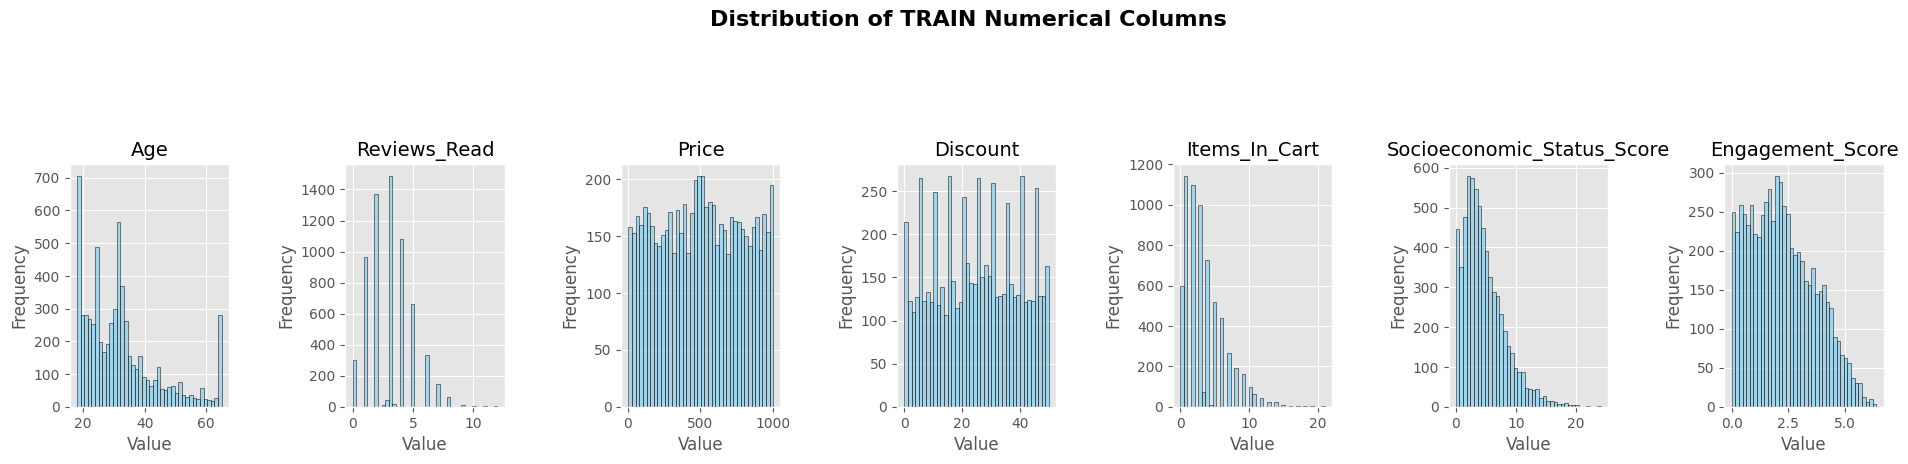

In [16]:
### TRAIN DATA

plt.style.use('ggplot')

fig, axs = plt.subplots(1, len(numerical_cols), figsize=(20, 5))
fig.suptitle('Distribution of TRAIN Numerical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

for i, col in enumerate(numerical_cols):
    axs[i].hist(data_imputed_full[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) 
    axs[i].set_title(col, fontsize=14)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
plt.show()

In [17]:
def transformation(df):
    df_copy = df.copy()
    df_copy['Engagement_Score'] = df_copy['Engagement_Score'].apply(lambda x: np.sqrt(x))
    df_copy['Reviews_Read'] = df_copy['Reviews_Read'].apply(lambda x: np.sqrt(x))
    df_copy['Age'] = df_copy['Age'].apply(lambda x: 1/(x+0.1))

    df_copy['Items_In_Cart'] = df_copy['Items_In_Cart'].apply(lambda x: np.log2(x + 1))
    df_copy['Socioeconomic_Status_Score'] = df_copy['Socioeconomic_Status_Score'].apply(lambda x: np.log2(x + 1))

    return df_copy

In [18]:
# Transform train and test data to make it less skewed
X_train = transformation(data_imputed_X_train)
X_test = transformation(data_imputed_X_test)

# Transform all train data to make it less skewed
data_transformed = transformation(data_imputed_full)

# Transform test data to make it less skewed
data_transformed_test = transformation(data_imputed_test)


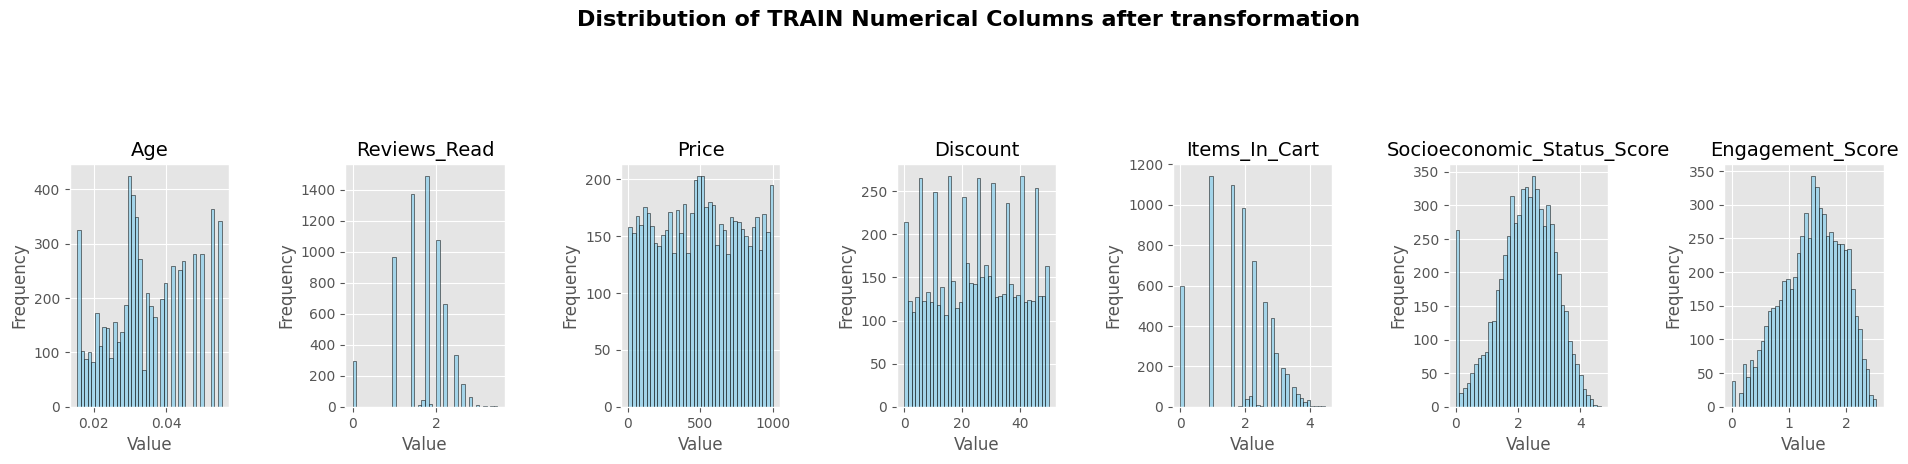

In [19]:
### TRAIN DATA

plt.style.use('ggplot')

fig, axs = plt.subplots(1, len(numerical_cols), figsize=(20, 5))
fig.suptitle('Distribution of TRAIN Numerical Columns after transformation', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

for i, col in enumerate(numerical_cols):
    axs[i].hist(data_transformed[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) 
    axs[i].set_title(col, fontsize=14)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)

plt.show()

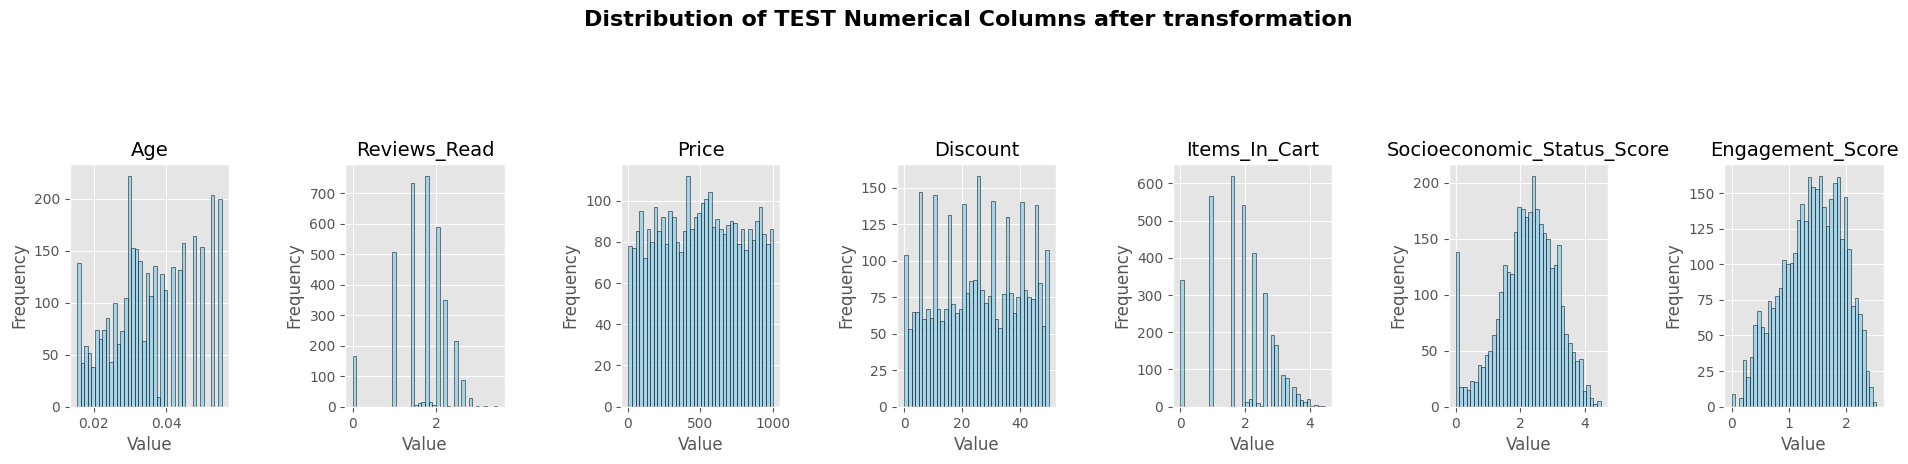

In [20]:
### TEST DATA

# Set a consistent style for better aesthetics
plt.style.use('ggplot')

fig, axs = plt.subplots(1, len(numerical_cols), figsize=(20, 5))
fig.suptitle('Distribution of TEST Numerical Columns after transformation', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

for i, col in enumerate(numerical_cols):
    axs[i].hist(data_transformed_test[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) #data[col].dropna()
    axs[i].set_title(col, fontsize=14)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)

plt.show()

#### categorical variables

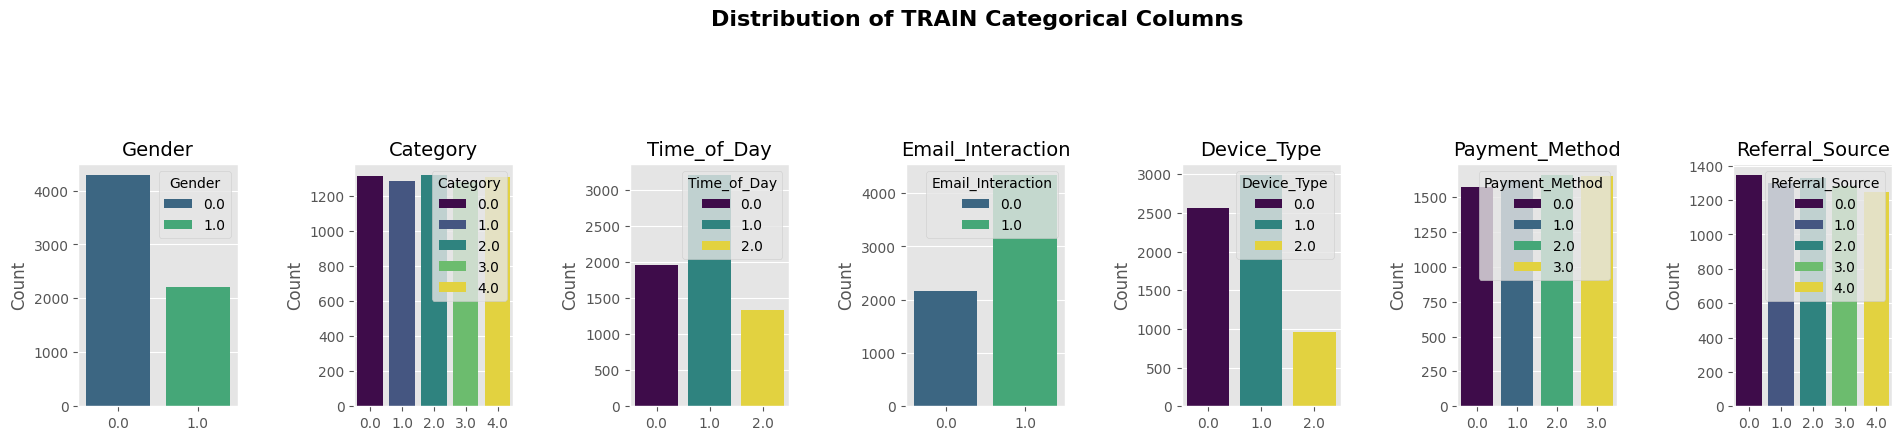

In [21]:
### TRAIN DATA

fig, axs = plt.subplots(1, len(categorical_cols), figsize=(20, 5))
fig.suptitle('Distribution of TRAIN Categorical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=data_transformed, ax=axs[i], palette='viridis', hue=f'{col}')
    axs[i].set_title(col, fontsize=14)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Count', fontsize=12)

plt.show()


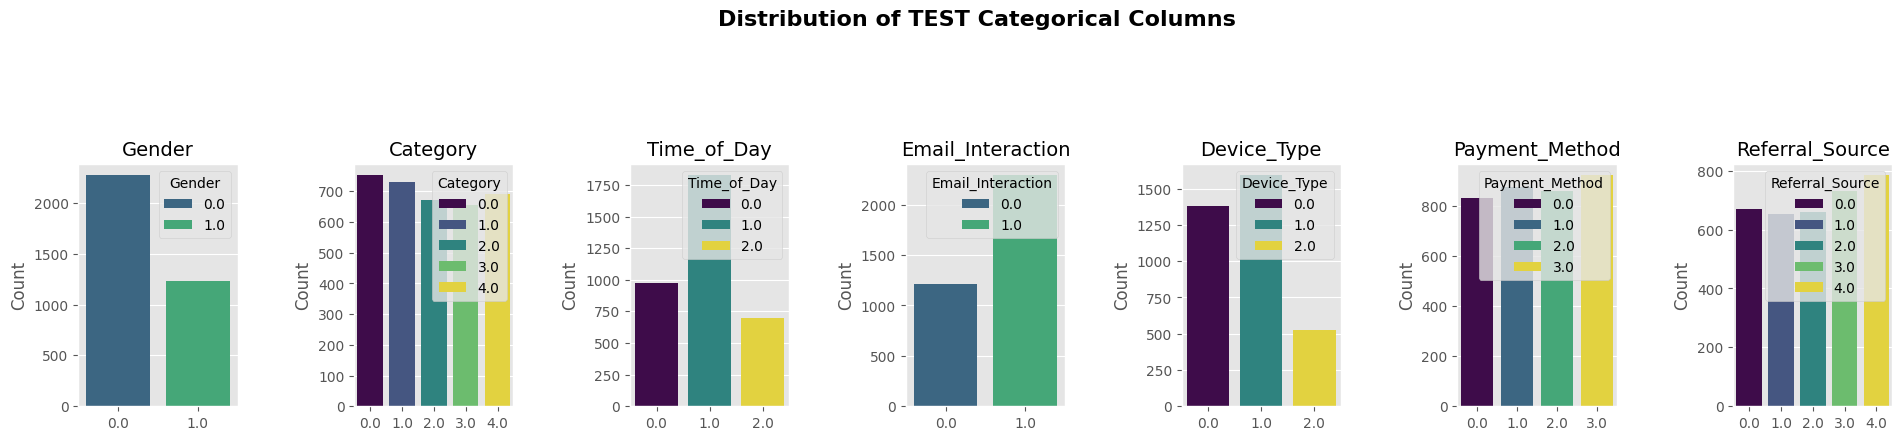

In [22]:
### TEST DATA

fig, axs = plt.subplots(1, 7, figsize=(20, 5))
fig.suptitle('Distribution of TEST Categorical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=data_transformed_test, ax=axs[i], palette='viridis', hue=f'{col}')
    axs[i].set_title(col, fontsize=14)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Count', fontsize=12)

plt.show()


## Feature selection

### 5) Do data standartization. Cap outliers

In [23]:
# separate data
X = data_transformed.drop(columns='Purchase')
y = data_transformed['Purchase']

X_target = data_transformed_test.copy()

In [24]:
# one hot encoding 

X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)
X = pd.get_dummies(X, columns=categorical_cols)
X_target = pd.get_dummies(X_target, columns=categorical_cols)

X_train = X_train.replace({True: 1.0, False: 0.0})
X_test = X_test.replace({True: 1.0, False: 0.0})
X = X.replace({True: 1.0, False: 0.0})
X_target = X_target.replace({True: 1.0, False: 0.0})

categorical_cols_ohe = [i for i in X_train.columns.tolist() if (i not in numerical_cols) and (i != 'Purchase')]

In [25]:
# standartize data

for col in X_train.columns.tolist():
    X_train[col] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
    X_test[col] = (X_test[col] - X_test[col].mean()) / X_test[col].std()
    X[col] = (X[col] - X[col].mean()) / X[col].std()
    X_target[col] = (X_target[col] - X_target[col].mean()) / X_target[col].std()

In [26]:
# Outliers: cap them

def cap_outliers(data, lower_percentile, upper_percentile):

    data = pd.Series(data)   
    # Calculate the lower and upper bounds
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    
    # Cap the outliers with those bounds
    capped_data = data.clip(lower=lower_bound, upper=upper_bound)
    
    return capped_data, lower_bound, upper_bound

# cap outliers
for col in numerical_cols:
    X_train[col] = cap_outliers(X_train[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X_test[col] = cap_outliers(X_test[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X[col] = cap_outliers(X[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X_target[col] = cap_outliers(X_target[col], lower_percentile=2.5, upper_percentile=97.5)[0]  

### 6) Feature selection with PCA

In [27]:
# TRAIN-TEST DATA

pca_full = PCA()
pca_full.fit(X_train)

# Determine how many components are required for 80% explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_80 = np.searchsorted(cumulative_variance, 0.80) + 1

print(f"Number of components to cover 80% variance: {n_components_80}")

# Refit PCA with the exact number of components
pca = PCA(n_components=n_components_80)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Number of components to cover 80% variance: 18


In [28]:
# ALL DATA

pca_full = PCA()
pca_full.fit(X)

# Determine how many components are required for 80% explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_80 = np.searchsorted(cumulative_variance, 0.80) + 1

print(f"Number of components to cover 80% variance: {n_components_80}")

pca = PCA(n_components=n_components_80)
X_pca = pca.fit_transform(X)
X_target_pca = pca.transform(X_target)

Number of components to cover 80% variance: 18


## Model estimation

### 7) Fit several classic ML models on train-test data, taking into account balance of classes. Compare their scores. Assess PCA usefulness

In [29]:
# Balance of classes

zeros, ones = y_train.value_counts()
print(f'0: {zeros}, 1: {ones}')
custom_weights = {0: 1.0, 1: np.round(zeros/ones, 3)}
custom_weights 

0: 3280, 1: 1920


{0: 1.0, 1: 1.708}

In [30]:
### Define models & param grids
models_and_grids = [
    (
        LogisticRegression(max_iter=10000, class_weight=custom_weights, random_state=42),
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100]
         },
        "Logistic Regression"
    ),
    (
        SVC(kernel='linear', max_iter=10000, class_weight=custom_weights, random_state=42),
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100]
         },
        "Linear SVC"
    ),
    (
        SVC(kernel='rbf', class_weight=custom_weights, random_state=42),
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 10, 100]
        },
        "RBF SVC"
    ),
    (
        RandomForestClassifier(class_weight = custom_weights, random_state=42),
        {
            'n_estimators': [10, 30, 60, 100, 200],
            'max_depth': [None, 1, 3, 6, 10, 20]
        },
        "Random Forest"
    ),
    (
        AdaBoostClassifier(RandomForestClassifier(class_weight=custom_weights, random_state=42), random_state=42),
        {
            'estimator__n_estimators': [50, 100, 150],
            'estimator__max_depth': [None, 10, 20],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        },
        "AdaBoost"
    )
]

### Approach A: no PCA
print("=== Approach A: no PCA ===\n")
best_models_no_pca, optimal_thresholds_no_pca = GridSearchCV_fun(X_train, y_train, models_and_grids)

# Evaluate Approach A on the test set
test_scores_no_pca, best_model_no_pca = get_scores(X_test, y_test, best_models_no_pca, optimal_thresholds_no_pca)
print("--------------------------------------------------------\n")


### Approach B: with PCA (selecting components to cover 80% variance)
print("=== Approach B: with PCA ===\n")
print(f"Number of components covering >=80% variance: {n_components_80}\n")
best_models_pca, optimal_thresholds_pca = GridSearchCV_fun(X_train_pca, y_train, models_and_grids)

# Evaluate Approach B on the test set
test_scores_pca, best_model_pca = get_scores(X_test_pca, y_test, best_models_pca, optimal_thresholds_pca)
print("--------------------------------------------------------\n")


# 5) Final comparison: no PCA vs with PCA

print("=== Final comparison on test set ===")
for name in best_models_no_pca.keys():
    score_no_pca = test_scores_no_pca[name]
    score_pca = test_scores_pca[name]
    print(
        f"{name}\n"
        f"  -> No PCA:   F1(macro)={score_no_pca:.4f}\n"
        f"  -> With PCA: F1(macro)={score_pca:.4f}\n"
    )
print("--------------------------------------------------------\n")
print("=== Best models ===", 
      f'No PCA: {best_model_no_pca}, F1 (macro): {test_scores_no_pca[best_model_no_pca]}', 
      f'With PCA: {best_model_pca}, F1 (macro): {test_scores_pca[best_model_pca]}', 
      sep='\n')


=== Approach A: no PCA ===

Logistic Regression Optimal Threshold: 0.5160

Logistic Regression CV best F1 (macro): 0.7269

Linear SVC does not support predict_proba, using default threshold of 0.5.

Linear SVC CV best F1 (macro): 0.7107

RBF SVC does not support predict_proba, using default threshold of 0.5.

RBF SVC CV best F1 (macro): 0.7149

Random Forest Optimal Threshold: 0.4257

Random Forest CV best F1 (macro): 0.7273

AdaBoost Optimal Threshold: 0.6134

AdaBoost CV best F1 (macro): 0.7262

--------------------------------------------------------

=== Approach B: with PCA ===

Number of components covering >=80% variance: 18

Logistic Regression Optimal Threshold: 0.5185

Logistic Regression CV best F1 (macro): 0.6991

Linear SVC does not support predict_proba, using default threshold of 0.5.

Linear SVC CV best F1 (macro): 0.7011

RBF SVC does not support predict_proba, using default threshold of 0.5.

RBF SVC CV best F1 (macro): 0.7021

Random Forest Optimal Threshold: 0.4430


### 8) Train NN 

In [31]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [32]:
# Set the random seed for reproducibility
random_state = 42
torch.manual_seed(random_state)  # PyTorch CPU random seed
torch.cuda.manual_seed_all(random_state)  # PyTorch GPU random seed
np.random.seed(random_state)  # NumPy random seed
random.seed(random_state)  # Python's random seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


param_grid = {
    "hidden_layers": [[64, 32, 16], [16, 64, 32], [32, 16]],
    "activation_fn": [nn.ReLU, nn.Tanh],
    "dropout_rate": [0.2, 0.3, 0.4],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.001, 0.0001],
    "batch_size": [128],
    "epochs": [4]
}

# Run stratified cross-validation No PCA
results_no_pca = stratified_cross_validate_nn_with_optimal_threshold(X_train, y_train, param_grid)

# With PCA
results_pca = stratified_cross_validate_nn_with_optimal_threshold(pd.DataFrame(X_train_pca), y_train, param_grid)

In [33]:
# Sort results by f1-score given no PCA
results_no_pca.sort(key=lambda x: x[1], reverse=True)
print("Top Configurations:")
for config, score in results_no_pca[:3]:
    print(f"Config: {config}, Macro F1-Score: {score:.4f}")

Top Configurations:
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7254
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7252
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7247


In [34]:
# Make prediction and assess f1 score

# No PCA
best_config_no_pca = results_no_pca[0][0]
y_pred_test_no_pca = nn_predictions(X_train, y_train, X_test, best_config_no_pca)
f1_no_pca = f1_score(y_test, y_pred_test_no_pca, average='macro')

# With PCA
best_config_pca = results_pca[0][0]
y_pred_test_pca = nn_predictions(pd.DataFrame(X_train_pca), y_train, pd.DataFrame(X_test_pca), best_config_pca)
f1_pca = f1_score(y_test, y_pred_test_pca, average='macro')

print("=== Best models ===", 
      f'No PCA: F1 (macro): {f1_no_pca}', 
      f'With PCA: F1 (macro): {f1_pca}', 
      sep='\n')

Optimal Threshold: 0.5234
Optimal Threshold: 0.4413
=== Best models ===
No PCA: F1 (macro): 0.733090842776674
With PCA: F1 (macro): 0.7203234859819481


## Training Model on all training dataset

### 9) Finetune best model via CV

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scorer = make_scorer(f1_score, average='macro')

best_model = RandomForestClassifier(class_weight = custom_weights, random_state=42)
param_grid = {
        'n_estimators': [10, 30, 60, 100, 200],
        'max_depth': [None, 1, 3, 6, 10, 20]
    }
name = "Random Forest"

grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        scoring=f1_macro_scorer,
        cv=cv,
        n_jobs=-1
    )
grid_search.fit(X, y)
best_models_no_pca[name] = grid_search.best_estimator_

print(f"{name} best params: {grid_search.best_params_}")
print(f"{name} CV best F1 (macro): {grid_search.best_score_:.4f}\n")

Random Forest best params: {'max_depth': 10, 'n_estimators': 200}
Random Forest CV best F1 (macro): 0.7294



In [36]:
# select best thresholds
trained_model = grid_search.best_estimator_
if hasattr(trained_model, 'predict_proba'):
    y_probs_X = trained_model.predict_proba(X)[:, 1]
    y_probs_target = trained_model.predict_proba(X_target)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_probs_X)

    optimal_threshold = thresholds[np.argmax(tpr - fpr)]
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    y_pred_target = (y_probs_target >= optimal_threshold).astype(int)
else:
    y_pred_target = trained_model.predict(X_target)
    print(f"Optimal Threshold: 0.5")

Optimal Threshold: 0.4345


In [37]:
# create_df
predictions_df = pd.DataFrame({
    'Id': X_target.index,
    'Purchase': y_pred_target
})

#predictions_df.to_csv('purchase_predictions_eval.csv', index=False)
print("Predictions saved to 'purchase_predictions_eval.csv'")

Predictions saved to 'purchase_predictions_eval.csv'


In [38]:
predictions_df

Id  Purchase
0     6500         0
1     6501         1
2     6502         1
3     6503         0
4     6504         0
...    ...       ...
3495  9995         1
3496  9996         1
3497  9997         0
3498  9998         1
3499  9999         0

[3500 rows x 2 columns]

### 9) if it's NN

In [40]:
param_grid = {
    "hidden_layers": [[64, 32, 16], [16, 64, 32], [32, 16]],
    "activation_fn": [nn.ReLU, nn.Tanh],
    "dropout_rate": [0.2, 0.3, 0.4],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.001, 0.0001],
    "batch_size": [128],
    "epochs": [4]
}

# Run stratified cross-validation
results = stratified_cross_validate_nn_with_optimal_threshold(X_train, y_train, param_grid)

In [41]:
# Sort results by f1-score
results.sort(key=lambda x: x[1], reverse=True)
print("Top Configurations:")
for config, score in results[:5]:
    print(f"Config: {config}, Macro F1-Score: {score:.4f}")

Top Configurations:
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7254
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7252
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7247
Config: {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7246
Config: {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modu

In [42]:
# Forecast on all data
# Run stratified cross-validation
results = stratified_cross_validate_nn_with_optimal_threshold(X, y, param_grid)

best_config = results[0][0]
y_pred_target = nn_predictions(X, y, X_target, best_config)

Optimal Threshold: 0.4953


In [43]:
# create_df
predictions_df_nn = pd.DataFrame({
    'Id': X_target.index,
    'Purchase': y_pred_target
})

#predictions_df_nn.to_csv('purchase_predictions_eval_nn.csv', index=False)
print("Predictions saved to 'purchase_predictions_eval_nn.csv'")

Predictions saved to 'purchase_predictions_eval_nn.csv'


In [44]:
predictions_df_nn

Id  Purchase
0     6500         0
1     6501         1
2     6502         1
3     6503         0
4     6504         0
...    ...       ...
3495  9995         1
3496  9996         1
3497  9997         0
3498  9998         0
3499  9999         0

[3500 rows x 2 columns]